# Spark ML для задачи оттока

Источник данных: [Kaggle](https://www.kaggle.com/sakshigoyal7/credit-card-customers)

Описания полей:

 | Название        | Описание                                                                                                                            |
 |:----------------|:------------------------------------------------------------------------------------------------------------------------------------|
 | CLIENTNUM       | Client number. Unique identifier for the customer holding the account                                                               |
 | Attrition_Flag  | Internal event (customer activity) variable                                                                                         |
 | Customer_Age    | Demographic variable - Customer's Age in Years                                                                                      |
 | Gender          | Demographic variable - M=Male, F=Female                                                                                             |
 | Dependent_count | Demographic variable - Number of dependents                                                                                         |
 | Education_Level | Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)               |
 | Marital_Status  | Demographic variable - Married, Single, Divorced, Unknown                                                                           |
 | Income_Category | Demographic variable - Annual Income Category of the account holder (< $40K, $40K - 60K, $60K - $80K, $80K-$120K, > $120K, Unknown) |
 | Card_Category   | Product Variable - Type of Card (Blue, Silver, Gold, Platinum)                                                                      |
 | Months_on_book  | Period of relationship with bank                                                                                                    |

In [1]:
!pip install findspark

Defaulting to user installation because normal site-packages is not writeable


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f 

spark = SparkSession\
    .builder\
    .master("local[*]")\
    .appName("Spark ML Research")\
    .getOrCreate()

In [46]:
import pyspark
pyspark.__version__

'3.0.3'

## Загрузка и знакомство с данными

In [5]:
df = spark.read.csv("data/BankChurners.csv", header=True, inferSchema=True)

### Убираем первую и последние две колонки

In [6]:
columns = df.columns
columnsLen = len(columns)
colsToDrop = columns[0].split() + columns[columnsLen-2:columnsLen]

df = df.drop(*colsToDrop)

df.limit(5).toPandas()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


### Определяем типы колонок

In [7]:
df.printSchema()

root
 |-- Attrition_Flag: string (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (nullable = true)



In [8]:
dt = df.dtypes

for r in dt:
    print(f"{r[0]:>25}\t{r[1]}")

           Attrition_Flag	string
             Customer_Age	int
                   Gender	string
          Dependent_count	int
          Education_Level	string
           Marital_Status	string
          Income_Category	string
            Card_Category	string
           Months_on_book	int
 Total_Relationship_Count	int
   Months_Inactive_12_mon	int
    Contacts_Count_12_mon	int
             Credit_Limit	double
      Total_Revolving_Bal	int
          Avg_Open_To_Buy	double
     Total_Amt_Chng_Q4_Q1	double
          Total_Trans_Amt	int
           Total_Trans_Ct	int
      Total_Ct_Chng_Q4_Q1	double
    Avg_Utilization_Ratio	double


In [9]:
from itertools import groupby

dt.sort(key=lambda x: x[1])

for k, g in groupby(dt, lambda x: x[1]):
    print(k, len(list(g)))

double 5
int 9
string 6


### Проверим числовые колонки

In [11]:
numericColumns = list(
    map(
        lambda x: x[0], 
        filter(lambda x: x[1] == "double" or x[1] == "int", df.dtypes)
    )
)
numericColumns

['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [12]:
df.select(*numericColumns).summary().toPandas()

,summary,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,count,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127,10127
1,mean,46.32596030413745,2.3462032191172115,35.928409203120374,3.8125802310654686,2.3411671768539546,2.4553174681544387,8631.953698034848,1162.8140614199665,7469.139636614887,0.7599406536980376,4404.086303939963,64.85869457884863,0.7122223758269962,0.2748935518909845
2,stddev,8.016814032549046,1.29890834890379,7.98641633087208,1.55440786533883,1.0106223994182844,1.1062251426359249,9088.776650223148,814.9873352357533,9090.685323679114,0.2192067692307027,3397.129253557085,23.47257044923301,0.23808609133294137,0.27569146925238736
3,min,26,0,13,1,0,0,1438.3,0,3.0,0.0,510,10,0.0,0.0
4,25%,41,1,31,3,2,2,2555.0,357,1322.0,0.631,2155,45,0.581,0.022
5,50%,46,2,36,4,2,2,4549.0,1276,3472.0,0.736,3899,67,0.702,0.175
6,75%,52,3,40,5,3,3,11067.0,1784,9857.0,0.859,4741,81,0.818,0.503
7,max,73,5,56,6,6,6,34516.0,2517,34516.0,3.397,18484,139,3.714,0.999


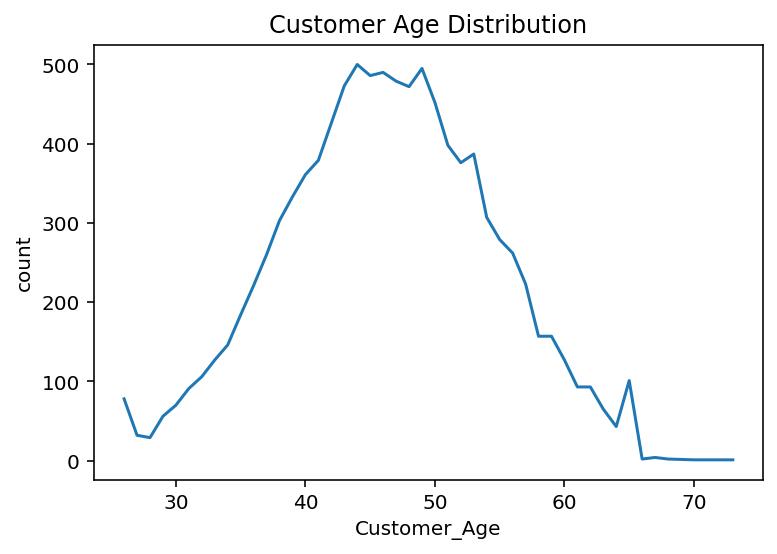

In [14]:
import matplotlib.pyplot as plt

age = df.groupBy("Customer_Age").count().orderBy("Customer_Age")
x_val = [val["Customer_Age"] for val in age.select("Customer_Age").collect()]
y_val = [val["count"] for val in age.select("count").collect()]

plt.plot(x_val, y_val)

plt.xlabel("Customer_Age")
plt.ylabel("count")
plt.title("Customer Age Distribution")

plt.show()

In [20]:
#age.select("Customer_Age").collect()

## Создадим колонку с целевая переменной

In [21]:
dft = df.withColumn(
    "target", 
    f.when(df["Attrition_Flag"] == "Existing Customer", 0).otherwise(1)
)

dft.select("Attrition_Flag", "target").show(5, False)

+-----------------+------+
|Attrition_Flag   |target|
+-----------------+------+
|Existing Customer|0     |
|Existing Customer|0     |
|Existing Customer|0     |
|Existing Customer|0     |
|Existing Customer|0     |
+-----------------+------+
only showing top 5 rows



### Проверка сбалансированности данных

In [22]:
dft.groupBy("target").count().show()

+------+-----+
|target|count|
+------+-----+
|     1| 1627|
|     0| 8500|
+------+-----+



### Oversampling

In [23]:
df1 = dft.filter(dft["target"] == 1)
df0 = dft.filter(dft["target"] == 0)

df1count = df1.count()
df0count = df0.count()

trate = int(df0count / df1count)
trate

5

### Как работает explode

In [43]:
test_df = spark.createDataFrame(
    [
        ['Peter',  ['python', 'C/C++', 'rust', 'golang']],
        ['Eugene', ['java', 'scala', 'kotlin']]
    ],
    ['Name', 'Languages']
)
test_df.toPandas()

,Name,Languages
0,Peter,"[python, C/C++, rust, golang]"
1,Eugene,"[java, scala, kotlin]"


In [44]:
test_df.explode('Name')

AttributeError: 'DataFrame' object has no attribute 'explode'

In [36]:
df1Over = df1.withColumn(
    "dummy", 
    f.explode(
        f.array(*[f.lit(x) for x in range(trate)])
    )
).drop("dummy")

df1Over.limit(10).toPandas()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,target
0,Attrited Customer,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,...,3,1438.3,0,1438.3,1.047,692,16,0.600,0.000,1
1,Attrited Customer,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,...,3,1438.3,0,1438.3,1.047,692,16,0.600,0.000,1
2,Attrited Customer,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,...,3,1438.3,0,1438.3,1.047,692,16,0.600,0.000,1
3,Attrited Customer,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,...,3,1438.3,0,1438.3,1.047,692,16,0.600,0.000,1
4,Attrited Customer,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,...,3,1438.3,0,1438.3,1.047,692,16,0.600,0.000,1
5,Attrited Customer,66,F,0,Doctorate,Married,Unknown,Blue,56,5,...,3,7882.0,605,7277.0,1.052,704,16,0.143,0.077,1
6,Attrited Customer,66,F,0,Doctorate,Married,Unknown,Blue,56,5,...,3,7882.0,605,7277.0,1.052,704,16,0.143,0.077,1
7,Attrited Customer,66,F,0,Doctorate,Married,Unknown,Blue,56,5,...,3,7882.0,605,7277.0,1.052,704,16,0.143,0.077,1
8,Attrited Customer,66,F,0,Doctorate,Married,Unknown,Blue,56,5,...,3,7882.0,605,7277.0,1.052,704,16,0.143,0.077,1
9,Attrited Customer,66,F,0,Doctorate,Married,Unknown,Blue,56,5,...,3,7882.0,605,7277.0,1.052,704,16,0.143,0.077,1


+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+----+
|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|target|xxxx|
+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------

In [44]:
data = df0.unionAll(df1Over)
data.groupBy("target").count().show()

+------+-----+
|target|count|
+------+-----+
|     1| 8135|
|     0| 8500|
+------+-----+



## Работа с признаками

### Проверим корреляции числовых признаков

#### Вариант 1: DataFrameStatFunctions

In [45]:
from itertools import combinations

numericColumnsPairs = list(combinations(numericColumns, 2))
numericColumnsPairs

[('Customer_Age', 'Dependent_count'),
 ('Customer_Age', 'Months_on_book'),
 ('Customer_Age', 'Total_Relationship_Count'),
 ('Customer_Age', 'Months_Inactive_12_mon'),
 ('Customer_Age', 'Contacts_Count_12_mon'),
 ('Customer_Age', 'Credit_Limit'),
 ('Customer_Age', 'Total_Revolving_Bal'),
 ('Customer_Age', 'Avg_Open_To_Buy'),
 ('Customer_Age', 'Total_Amt_Chng_Q4_Q1'),
 ('Customer_Age', 'Total_Trans_Amt'),
 ('Customer_Age', 'Total_Trans_Ct'),
 ('Customer_Age', 'Total_Ct_Chng_Q4_Q1'),
 ('Customer_Age', 'Avg_Utilization_Ratio'),
 ('Dependent_count', 'Months_on_book'),
 ('Dependent_count', 'Total_Relationship_Count'),
 ('Dependent_count', 'Months_Inactive_12_mon'),
 ('Dependent_count', 'Contacts_Count_12_mon'),
 ('Dependent_count', 'Credit_Limit'),
 ('Dependent_count', 'Total_Revolving_Bal'),
 ('Dependent_count', 'Avg_Open_To_Buy'),
 ('Dependent_count', 'Total_Amt_Chng_Q4_Q1'),
 ('Dependent_count', 'Total_Trans_Amt'),
 ('Dependent_count', 'Total_Trans_Ct'),
 ('Dependent_count', 'Total_Ct_Chn

In [46]:
corr = list(
    filter(
        lambda x: abs(x[2]) > 0.6, 
        map(lambda x: (x[0], x[1], data.stat.corr(x[0], x[1])), numericColumnsPairs)
    )
)

In [47]:
corr.sort(key=lambda x: x[2])
for i in reversed(corr):
    print(f"{i[0]:>25} {i[1]:>25}\t{i[2]}")

             Credit_Limit           Avg_Open_To_Buy	0.9952040726156255
          Total_Trans_Amt            Total_Trans_Ct	0.8053901681243808
             Customer_Age            Months_on_book	0.7805047706891142
      Total_Revolving_Bal     Avg_Utilization_Ratio	0.6946855441968229


#### Вариант 2: Correlation

In [18]:
numericColumnsPairsFull = list(map(lambda z: z[1], map(lambda x: [x, list(map(lambda y: (x, y), numericColumns))], numericColumns)))
numericColumnsPairsFull

[[('Customer_Age', 'Customer_Age'),
  ('Customer_Age', 'Dependent_count'),
  ('Customer_Age', 'Months_on_book'),
  ('Customer_Age', 'Total_Relationship_Count'),
  ('Customer_Age', 'Months_Inactive_12_mon'),
  ('Customer_Age', 'Contacts_Count_12_mon'),
  ('Customer_Age', 'Credit_Limit'),
  ('Customer_Age', 'Total_Revolving_Bal'),
  ('Customer_Age', 'Avg_Open_To_Buy'),
  ('Customer_Age', 'Total_Amt_Chng_Q4_Q1'),
  ('Customer_Age', 'Total_Trans_Amt'),
  ('Customer_Age', 'Total_Trans_Ct'),
  ('Customer_Age', 'Total_Ct_Chng_Q4_Q1'),
  ('Customer_Age', 'Avg_Utilization_Ratio')],
 [('Dependent_count', 'Customer_Age'),
  ('Dependent_count', 'Dependent_count'),
  ('Dependent_count', 'Months_on_book'),
  ('Dependent_count', 'Total_Relationship_Count'),
  ('Dependent_count', 'Months_Inactive_12_mon'),
  ('Dependent_count', 'Contacts_Count_12_mon'),
  ('Dependent_count', 'Credit_Limit'),
  ('Dependent_count', 'Total_Revolving_Bal'),
  ('Dependent_count', 'Avg_Open_To_Buy'),
  ('Dependent_count', '

In [19]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

numericAssembler = VectorAssembler()\
    .setInputCols(numericColumns)\
    .setOutputCol("features")

numeric = numericAssembler.transform(data)
matrix = Correlation.corr(numeric, "features").head().asDict()['pearson(features)'].toArray().tolist()

In [20]:
matrix

[[1.0,
  -0.13575515707704905,
  0.780504770689084,
  -0.026525310066417403,
  0.13116552936201348,
  -0.019944405497176732,
  0.016657097778483475,
  -0.002841536593767456,
  0.016929170875654043,
  -0.020559135165498028,
  -0.06586475313340744,
  -0.07815083273365253,
  -0.016568818333932693,
  -0.010985827540562288],
 [-0.13575515707704905,
  1.0,
  -0.11728062823959522,
  -0.03266417786351196,
  -0.010657501150598976,
  -0.02566496168277401,
  0.06002070339266479,
  0.0018723592997836101,
  0.05981512203616065,
  -0.04794367154504479,
  0.00700430540503166,
  0.025513406218718206,
  -0.019666216088456825,
  -0.03300255953641679],
 [0.780504770689084,
  -0.11728062823959522,
  1.0,
  -0.017395648588812672,
  0.17573226369307368,
  -0.018581210990133486,
  0.01736017181943523,
  0.002027784037740437,
  0.017155177760641748,
  -0.016079093535360012,
  -0.05568529445298156,
  -0.05906597721356735,
  -0.021148786215887182,
  -0.018757073876222614],
 [-0.026525310066417403,
  -0.03266417

In [21]:
def generate_cor_pairs(m, n):
    for x in range(0, len(m)):
        for y in range(0, len(m[0])):
            yield abs(matrix[x][y]), n[x][y]
            
cor_pairs = list(generate_cor_pairs(matrix, numericColumnsPairsFull))

In [22]:
corr2 = list(
    set(
        map(lambda x: (x[0], x[1][0], x[1][1]) if x[1][0] < x[1][1] else (x[0], x[1][1], x[1][0]),
            (filter(lambda x: 0.6 < x[0] < 1, cor_pairs)))))

In [23]:
corr2.sort(key=lambda x: x[0])
for i in reversed(corr2):
    print(f"{i[1]:>25} {i[2]:>25}\t{i[0]}")

          Avg_Open_To_Buy              Credit_Limit	0.9952040726156179
          Total_Trans_Amt            Total_Trans_Ct	0.8053901681243786
             Customer_Age            Months_on_book	0.780504770689084
    Avg_Utilization_Ratio       Total_Revolving_Bal	0.6946855441968222


In [24]:
set(corr).intersection(set(corr2))

set()

#### Оставляем числовые колонки с низкой кореляцией

In [25]:
numericColumnsFinal = list(
    set(numericColumns) - set(map(lambda x: x[1], corr)))

numericColumnsFinal

['Dependent_count',
 'Contacts_Count_12_mon',
 'Total_Relationship_Count',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Total_Trans_Amt',
 'Total_Ct_Chng_Q4_Q1',
 'Total_Amt_Chng_Q4_Q1',
 'Months_Inactive_12_mon',
 'Customer_Age']

### Категориальные признаки

#### Индексируем строковые колонки

In [26]:
from pyspark.ml.feature import StringIndexer

stringColumns = list(
    filter(
        lambda x: x != "Attrition_Flag",
        map(lambda x: x[0], 
            filter(lambda x: x[1] == "string", data.dtypes))))

stringColumnsIndexed = list(map(lambda x: x + "_Indexed", stringColumns))

indexer = StringIndexer()\
    .setInputCols(stringColumns)\
    .setOutputCols(stringColumnsIndexed)

indexed = indexer.fit(data).transform(data)
indexed.show(5)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+--------------+-----------------------+----------------------+-----------------------+---------------------+
|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|target|Gender_Indexed|Education_Level_Indexed|Marital_Status_Indexed|Income_Category_Indexed|Card_Category_Indexed|
+-----------------+------------+------+---------------+---------------+---------

#### Кодируем категориальные признаки

In [27]:
from pyspark.ml.feature import OneHotEncoder

catColumns = list(map(lambda x: x + "_Coded", stringColumnsIndexed))
    
encoder = OneHotEncoder()\
    .setInputCols(stringColumnsIndexed)\
    .setOutputCols(catColumns)

encoded = encoder.fit(indexed).transform(indexed)
encoded.show(5)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+--------------+-----------------------+----------------------+-----------------------+---------------------+--------------------+-----------------------------+----------------------------+-----------------------------+---------------------------+
|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|target|Gender_Indexed|Education_Level_Indexed|Marital_Stat

### Собираем признаки в вектор

In [28]:
from pyspark.ml.feature import VectorAssembler

featureColumns = numericColumnsFinal + catColumns

assembler = VectorAssembler()\
    .setInputCols(featureColumns)\
    .setOutputCol("features")

assembled = assembler.transform(encoded)
assembled.show(5, truncate=False)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+--------------+-----------------------+----------------------+-----------------------+---------------------+--------------------+-----------------------------+----------------------------+-----------------------------+---------------------------+---------------------------------------------------------------------------------------------------------------------+
|Attrition_Flag   |Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_A

In [29]:
assembled.select("features").show(5, False)

+---------------------------------------------------------------------------------------------------------------------+
|features                                                                                                             |
+---------------------------------------------------------------------------------------------------------------------+
|(28,[0,1,2,3,4,5,6,7,8,9,12,17,23,25],[3.0,3.0,5.0,12691.0,777.0,1144.0,1.625,1.335,1.0,45.0,1.0,1.0,1.0,1.0])       |
|(28,[0,1,2,3,4,5,6,7,8,9,10,11,18,20,25],[5.0,2.0,6.0,8256.0,864.0,1291.0,3.714,1.541,1.0,49.0,1.0,1.0,1.0,1.0,1.0]) |
|(28,[0,2,3,5,6,7,8,9,11,17,22,25],[3.0,4.0,3418.0,1887.0,2.333,2.594,1.0,51.0,1.0,1.0,1.0,1.0])                      |
|(28,[0,1,2,3,4,5,6,7,8,9,10,12,19,20,25],[4.0,1.0,3.0,3313.0,2517.0,1171.0,2.333,1.405,4.0,40.0,1.0,1.0,1.0,1.0,1.0])|
|(28,[0,2,3,5,6,7,8,9,14,17,23,25],[3.0,5.0,4716.0,816.0,2.5,2.175,1.0,40.0,1.0,1.0,1.0,1.0])                         |
+---------------------------------------

### Нормализация

In [30]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler()\
    .setInputCol("features")\
    .setOutputCol("scaledFeatures")

scaled = scaler.fit(assembled).transform(assembled)

scaled.select("features", "scaledFeatures").show(5, False)

+---------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                             |scaledFeatures                                                                                                                                                                                                                |
+---------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Feature Selection (отбор признаков)

In [31]:
from pyspark.ml.feature import UnivariateFeatureSelector

selector = UnivariateFeatureSelector()\
    .setFeatureType("continuous")\
    .setLabelType("categorical")\
    .setSelectionMode("percentile")\
    .setSelectionThreshold(0.75)\
    .setFeaturesCol("scaledFeatures")\
    .setLabelCol("target")\
    .setOutputCol("selectedFeatures")

dataF = selector.fit(scaled).transform(scaled)

dataF.select("scaledFeatures", "selectedFeatures").show(5, False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaledFeatures                                                                                                                                                                                                                |selectedFeatures                                                                                                                                                                                                       |
+---------------------------------------------------------------------------------------------------------------------

## Моделирование

### Обучающая и тестовая выборки

In [32]:
tt = dataF.randomSplit([0.7, 0.3])
training = tt[0]
test = tt[1]

In [33]:
print(f"training\t{training.count():>5}\ntest    \t{test.count():>5}")

training	11650
test    	 4985


### Логистическая регрессия

In [34]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()\
    .setMaxIter(1000)\
    .setRegParam(0.2)\
    .setElasticNetParam(0.8)\
    .setFamily("binomial")\
    .setFeaturesCol("selectedFeatures")\
    .setLabelCol("target")

lrModel = lr.fit(training)

print(f"Coefficients: {lrModel.coefficients}\nIntercept: {lrModel.intercept}")

Coefficients: (21,[4,6],[-0.013032788260828463,-1.5969795817106993])
Intercept: 0.24320472749666736


### Training Summary

In [35]:
trainingSummary = lrModel.summary

print(f"accuracy: {trainingSummary.accuracy}")
print(f"areaUnderROC: {trainingSummary.areaUnderROC}")

accuracy: 0.7074678111587983
areaUnderROC: 0.753910206467841


### Проверяем модель на тестовой выборке

In [36]:
predicted = lrModel.transform(test)

predicted.select("target", "prediction").show(10, False)

+------+----------+
|target|prediction|
+------+----------+
|0     |1.0       |
|0     |1.0       |
|0     |1.0       |
|0     |0.0       |
|0     |1.0       |
|0     |1.0       |
|0     |0.0       |
|0     |1.0       |
|0     |0.0       |
|0     |1.0       |
+------+----------+
only showing top 10 rows



In [37]:
predicted.show(5)

+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+------+--------------+-----------------------+----------------------+-----------------------+---------------------+--------------------+-----------------------------+----------------------------+-----------------------------+---------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt

In [38]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator().setLabelCol("target")

print(f"areaUnderROC: {evaluator.evaluate(predicted)}")

areaUnderROC: 0.748644337835456


#### Confusion Matrix (матрица ошибок)

* True Positive (TP) - label is positive and prediction is also positive
* True Negative (TN) - label is negative and prediction is also negative
* False Positive (FP) - label is negative but prediction is positive
* False Negative (FN) - label is positive but prediction is negative

In [39]:
tp = predicted.filter((f.col("target") == 1) & (f.col("prediction") == 1)).count()
tn = predicted.filter((f.col("target") == 0) & (f.col("prediction") == 0)).count()
fp = predicted.filter((f.col("target") == 0) & (f.col("prediction") == 1)).count()
fn = predicted.filter((f.col("target") == 1) & (f.col("prediction") == 0)).count()

print(f"Confusion Matrix:\n{tp:>4}\t{fp:>4}\n{fn:>4}\t{tn:>4}")

Confusion Matrix:
1353	 372
1078	2182


#### Accuracy, Precision, Recall

* Accuracy (доля правильных ответов) = TP + TN / TP + TN + FP + FN
* Precision (точность) = TP / TP + FP
* Recall (полнота) = TP / TP + FN

In [40]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print(f"Accuracy = {accuracy}")
print(f"Precision = {precision}")
print(f"Recall = {recall}")

Accuracy = 0.7091273821464393
Precision = 0.7843478260869565
Recall = 0.5565610859728507


## Настраиваем модель (подбираем гиперпараметры)

In [41]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.01, 0.1, 0.5])\
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

trainValidationSplit = TrainValidationSplit()\
    .setEstimator(lr)\
    .setEvaluator(evaluator)\
    .setEstimatorParamMaps(paramGrid)\
    .setTrainRatio(0.7)\
    .setParallelism(2)

model = trainValidationSplit.fit(dataF)

In [42]:
param_map = model.bestModel.extractParamMap()
for i in param_map:
    print(f"{i.name:<16}\t{param_map[i]}")

aggregationDepth	2
elasticNetParam 	0.5
family          	binomial
featuresCol     	selectedFeatures
fitIntercept    	True
labelCol        	target
maxBlockSizeInMB	0.0
maxIter         	1000
predictionCol   	prediction
probabilityCol  	probability
rawPredictionCol	rawPrediction
regParam        	0.01
standardization 	True
threshold       	0.5
tol             	1e-06


In [43]:
bestML = model.bestModel

## Собираем всё вместе (Pipeline)

1. Отобрали числовые признаки: numericColumnsFinal
2. Проиндексировали строковые признаки: indexer
3. Закодировали категориальные признаки: encoder
4. Собрали признаки в вектор: assembler
5. Нормализовали признаки: scaler
6. Провели отбор признаков: selector
7. Рассчитали модель: bestML 

In [44]:
from pyspark.ml import Pipeline

pipeline = Pipeline().setStages(
    [indexer, encoder, assembler, scaler, selector, bestML])

In [45]:
[trainingData, testData] = data.randomSplit([0.7, 0.3])

pipelineModel = pipeline.fit(trainingData)

## Сохраняем модель

In [46]:
pipelineModel.write().overwrite().save("../pipelineModel")